## Introduction

## Artwork_classification
**This is the task project for GSoC 2025 application for the ArtExtract Project.**

In this project, wikiart data was used. To classify the artist, genre, and style of the picture, two
different kinds of convolutional neural networks were used which are **AlextNet model** and
**ResNet model**. To save time, I have used Res50 as the basic model and re-train the last 20
layers.
After training the two models, I used soft voting to stack the two models. In soft voting, each base
model gives a probability or confidence estimate for each category, which is then averaged or
weighted. The final prediction is the category with the highest average probability (or weighted
average probability).

## Import libaray

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torchvision.models as models
import numpy as np

## Loading data

Both AlexNet and ResNet take 227*227 size of inputs. Thus, before building the model, I used the DataLoader tool in torch library to contribute the dataset.

In [6]:
artist = pd.read_csv('wikiart_csv/artist_train.csv')
artist.columns = ['path', 'artist']
gener = pd.read_csv('wikiart_csv/genre_train.csv')
gener.columns = ['path', 'genre']
style = pd.read_csv('wikiart_csv/style_train.csv')
style.columns =  ['path', 'style']

label_encoder = LabelEncoder()
artist['label'] = label_encoder.fit_transform(artist['artist'])
gener['label'] = label_encoder.fit_transform(gener['genre'])
style['label'] = label_encoder.fit_transform(style['style'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ArtDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.dataframe.iloc[idx]['path']}"
        try:
            image = Image.open(img_path).convert("RGB")  # 读取图片
        except (OSError, IOError):  # 捕获损坏文件错误
            print(f"Warning: Skipping corrupted image {img_path}")
            return self.__getitem__((idx + 1) % len(self.dataframe))  # 返回下一个样本
        
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        
        return image, label

img_dir = "wikiart"
artist_dataset = ArtDataset(artist, img_dir, transform)
genre_dataset = ArtDataset(gener, img_dir, transform)
style_dataset = ArtDataset(style, img_dir, transform)

train_size_artist = int(0.8 * len(artist_dataset))
train_size_genre = int(0.8 * len(genre_dataset))
train_size_style = int(0.8 * len(style_dataset))

val_size_artist = len(artist_dataset) - train_size_artist
val_size_genre = len(genre_dataset) - train_size_genre
val_size_style = len(style_dataset) - train_size_style

train_dataset_artist, val_dataset_artist = torch.utils.data.random_split(artist_dataset, [train_size_artist, val_size_artist])
train_dataset_genre, val_dataset_genre = torch.utils.data.random_split(genre_dataset, [train_size_genre, val_size_genre])
train_dataset_style, val_dataset_style = torch.utils.data.random_split(style_dataset, [train_size_style, val_size_style])

train_loader_artist = DataLoader(train_dataset_artist, batch_size=32, shuffle=True, num_workers=0)
val_loader_artist = DataLoader(val_dataset_artist, batch_size=32, shuffle=False, num_workers=0)

train_loader_genre = DataLoader(train_dataset_genre, batch_size=32, shuffle=True, num_workers=0)
val_loader_genre = DataLoader(val_dataset_genre, batch_size=32, shuffle=False, num_workers=0)

train_loader_style = DataLoader(train_dataset_style, batch_size=32, shuffle=True, num_workers=0)
val_loader_style = DataLoader(val_dataset_style, batch_size=32, shuffle=False, num_workers=0)


## AlexNet

At this cell, I built up the frame of alexnet model.

In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=23):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes), 
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50


then, let's train the artist part of the data

In [15]:
print('artist part tarning...')
model = AlexNet(num_classes=23).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_artist:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_artist):.4f}, Train Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "Alexnet_model_artist.pth")

print("artist part finished")


artist part tarning...
Epoch [1/50], Loss: 2.8638, Train Accuracy: 16.15%
Epoch [2/50], Loss: 2.5093, Train Accuracy: 26.09%
Epoch [3/50], Loss: 2.2832, Train Accuracy: 31.85%
Epoch [4/50], Loss: 2.1623, Train Accuracy: 35.29%
Epoch [5/50], Loss: 2.0659, Train Accuracy: 37.88%
Epoch [6/50], Loss: 1.9905, Train Accuracy: 40.28%
Epoch [7/50], Loss: 1.9114, Train Accuracy: 42.82%
Epoch [8/50], Loss: 1.8289, Train Accuracy: 44.89%
Epoch [9/50], Loss: 1.7743, Train Accuracy: 46.07%
Epoch [10/50], Loss: 1.6879, Train Accuracy: 47.99%
Epoch [11/50], Loss: 1.6476, Train Accuracy: 49.69%
Epoch [12/50], Loss: 1.5899, Train Accuracy: 51.16%
Epoch [13/50], Loss: 1.5283, Train Accuracy: 52.85%
Epoch [14/50], Loss: 1.4599, Train Accuracy: 55.07%
Epoch [15/50], Loss: 1.3980, Train Accuracy: 56.65%
Epoch [16/50], Loss: 1.3339, Train Accuracy: 58.47%
Epoch [17/50], Loss: 1.2844, Train Accuracy: 60.10%
Epoch [18/50], Loss: 1.2172, Train Accuracy: 62.11%
Epoch [19/50], Loss: 1.1664, Train Accuracy: 62.80

then the genre part

In [23]:
print('genre part tarning...')

model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_genre:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_genre):.4f}, Train Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "Alexnet_model_genre.pth")

print("genre part finished")

genre part tarning...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/50], Loss: 1.7048, Train Accuracy: 40.55%
Epoch [2/50], Loss: 1.4794, Train Accuracy: 48.44%
Epoch [3/50], Loss: 1.3852, Train Accuracy: 51.79%
Epoch [4/50], Loss: 1.3203, Train Accuracy: 54.10%
Epoch [5/50], Loss: 1.2628, Train Accuracy: 55.96%
Epoch [6/50], Loss: 1.2185, Train Accuracy: 57.72%
Epoch [7/50], Loss: 1.1759, Train Accuracy: 59.24%
Epoch [8/50], Loss: 1.1372, Train Accuracy: 60.33%
Epoch [9/50], Loss: 1.1014, Train Accuracy: 61.50%
Epoch [10/50], Loss: 1.0668, Train Accuracy: 62.73%
Epoch [11/50], Loss: 1.0437, Train Accuracy: 63.51%
Epoch [12/50], Loss: 1.0155, Train Accuracy: 64.11%
Epoch [13/50], Loss: 0.9825, Train Accuracy: 65.39%
Epoch [14/50], Loss: 0.9527, Train Accuracy: 66.40%
Epoch [15/50], Loss: 0.9328, Train Accuracy: 67.20%
Epoch [16/50], Loss: 0.9068, Train Accuracy: 67.97%
Epoch [17/50], Loss: 0.8775, Train Accuracy: 69.16%
Epoch [18/50], Loss: 0.8582, Train Accuracy: 69.70%
Epoch [19/50], Loss: 0.8317, Train Accuracy: 70.44%
Epoch [20/50], Loss: 

then the style part

In [24]:
print('style part tarning...')

model = AlexNet(num_classes=27).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_style:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_style):.4f}, Train Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "Alexnet_model_style.pth")

print("style part finished")

style part tarning...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/50], Loss: 2.6056, Train Accuracy: 20.12%
Epoch [2/50], Loss: 2.3263, Train Accuracy: 27.07%
Epoch [3/50], Loss: 2.2158, Train Accuracy: 30.21%
Epoch [4/50], Loss: 2.1433, Train Accuracy: 32.00%
Epoch [5/50], Loss: 2.0847, Train Accuracy: 33.48%
Epoch [6/50], Loss: 2.0351, Train Accuracy: 34.91%
Epoch [7/50], Loss: 1.9892, Train Accuracy: 36.18%
Epoch [8/50], Loss: 1.9390, Train Accuracy: 37.62%
Epoch [9/50], Loss: 1.8981, Train Accuracy: 38.87%
Epoch [10/50], Loss: 1.8594, Train Accuracy: 39.98%
Epoch [11/50], Loss: 1.8161, Train Accuracy: 41.18%
Epoch [12/50], Loss: 1.7739, Train Accuracy: 42.02%
Epoch [13/50], Loss: 1.7413, Train Accuracy: 43.17%
Epoch [14/50], Loss: 1.6941, Train Accuracy: 44.48%
Epoch [15/50], Loss: 1.6592, Train Accuracy: 45.43%
Epoch [16/50], Loss: 1.6183, Train Accuracy: 46.39%
Epoch [17/50], Loss: 1.5752, Train Accuracy: 47.82%
Epoch [18/50], Loss: 1.5385, Train Accuracy: 48.92%
Epoch [19/50], Loss: 1.4993, Train Accuracy: 50.28%
Epoch [20/50], Loss: 

## Resnet model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15

First train the artist data

In [26]:
model = models.resnet50()
model.load_state_dict(torch.load("/Users/adamlee/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth"))

for param in list(model.parameters())[:-20]:
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 23)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_artist:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_artist):.4f}, Train Acc: {train_acc:.2f}%")

torch.save(model.state_dict(), "Resnet_model_artist.pth")

print("Artist part done.")


Epoch [1/15], Loss: 1.4498, Train Acc: 57.77%
Epoch [2/15], Loss: 0.8179, Train Acc: 75.66%
Epoch [3/15], Loss: 0.6093, Train Acc: 81.69%
Epoch [4/15], Loss: 0.4932, Train Acc: 84.89%
Epoch [5/15], Loss: 0.3938, Train Acc: 87.66%
Epoch [6/15], Loss: 0.3251, Train Acc: 89.93%
Epoch [7/15], Loss: 0.2755, Train Acc: 91.29%
Epoch [8/15], Loss: 0.2232, Train Acc: 93.11%
Epoch [9/15], Loss: 0.2222, Train Acc: 93.15%
Epoch [10/15], Loss: 0.1807, Train Acc: 94.20%
Epoch [11/15], Loss: 0.1673, Train Acc: 94.28%
Epoch [12/15], Loss: 0.1481, Train Acc: 95.37%
Epoch [13/15], Loss: 0.1391, Train Acc: 95.63%
Epoch [14/15], Loss: 0.1322, Train Acc: 95.73%
Epoch [15/15], Loss: 0.1387, Train Acc: 95.60%
Artist part done.


Then the genre part

In [6]:
model = models.resnet50()
model.load_state_dict(torch.load("/Users/adamlee/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth"))

for param in list(model.parameters())[:-20]:
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_genre:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_genre):.4f}, Train Acc: {train_acc:.2f}%")

torch.save(model.state_dict(), "Resnet_model_genre.pth")

print("Genre part done.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/15], Loss: 0.9048, Train Acc: 68.65%
Epoch [2/15], Loss: 0.7347, Train Acc: 74.12%
Epoch [3/15], Loss: 0.6623, Train Acc: 76.64%
Epoch [4/15], Loss: 0.6102, Train Acc: 78.26%
Epoch [5/15], Loss: 0.5569, Train Acc: 79.93%
Epoch [6/15], Loss: 0.5140, Train Acc: 81.55%
Epoch [7/15], Loss: 0.4716, Train Acc: 83.18%
Epoch [8/15], Loss: 0.4268, Train Acc: 84.66%
Epoch [9/15], Loss: 0.3901, Train Acc: 85.77%
Epoch [10/15], Loss: 0.3636, Train Acc: 86.69%
Epoch [11/15], Loss: 0.3274, Train Acc: 87.97%
Epoch [12/15], Loss: 0.3036, Train Acc: 88.95%
Epoch [13/15], Loss: 0.2828, Train Acc: 89.66%
Epoch [14/15], Loss: 0.2612, Train Acc: 90.40%
Epoch [15/15], Loss: 0.2433, Train Acc: 91.06%
Genre part done.


finaly the style part

In [7]:
model = models.resnet50()
model.load_state_dict(torch.load("/Users/adamlee/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth"))

for param in list(model.parameters())[:-20]:
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_style:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_style):.4f}, Train Acc: {train_acc:.2f}%")

torch.save(model.state_dict(), "Resnet_model_style.pth")

print("Style part done.")


Epoch [1/15], Loss: 1.7185, Train Acc: 43.77%
Epoch [2/15], Loss: 1.4030, Train Acc: 53.09%
Epoch [3/15], Loss: 1.2667, Train Acc: 57.05%
Epoch [4/15], Loss: 1.1663, Train Acc: 60.12%
Epoch [5/15], Loss: 1.0771, Train Acc: 62.90%
Epoch [6/15], Loss: 0.9988, Train Acc: 65.64%
Epoch [7/15], Loss: 0.9275, Train Acc: 68.10%
Epoch [8/15], Loss: 0.8618, Train Acc: 69.72%
Epoch [9/15], Loss: 0.7924, Train Acc: 72.33%
Epoch [10/15], Loss: 0.7384, Train Acc: 74.09%
Epoch [11/15], Loss: 0.6924, Train Acc: 75.84%
Epoch [12/15], Loss: 0.6416, Train Acc: 77.40%
Epoch [13/15], Loss: 0.6029, Train Acc: 78.91%
Epoch [14/15], Loss: 0.5713, Train Acc: 79.73%
Epoch [15/15], Loss: 0.5280, Train Acc: 81.54%
Style part done.


## Stacking

In [10]:
import torchvision.models as models

model_Alex_artist = AlexNet(num_classes=23).to(device)
model_Alex_artist.load_state_dict(torch.load("Alexnet_model_artist.pth"))
model_Alex_artist.eval()

model_Alex_genre = AlexNet(num_classes=10).to(device)
model_Alex_genre.load_state_dict(torch.load("Alexnet_model_genre.pth"))
model_Alex_genre.eval()

model_Alex_style = AlexNet(num_classes=27).to(device)
model_Alex_style.load_state_dict(torch.load("Alexnet_model_style.pth"))
model_Alex_style.eval()

model_Res_artist = models.resnet50().to(device)
num_ftrs = model_Res_artist.fc.in_features 
model_Res_artist.fc = torch.nn.Linear(num_ftrs, 23) 
model_Res_artist.load_state_dict(torch.load('Resnet_model_artist.pth'))
model_Res_artist.eval()

model_Res_genre = models.resnet50().to(device)
num_ftrs = model_Res_genre.fc.in_features 
model_Res_genre.fc = torch.nn.Linear(num_ftrs, 10) 
model_Res_genre.load_state_dict(torch.load('Resnet_model_genre.pth'))
model_Res_genre.eval()

model_Res_style = models.resnet50().to(device)
num_ftrs = model_Res_style.fc.in_features 
model_Res_style.fc = torch.nn.Linear(num_ftrs, 27) 
model_Res_style.load_state_dict(torch.load('Resnet_model_style.pth'))
model_Res_style.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torch
import torch.nn.functional as F

def combined_prediction(alex_model, res_model, dataloader, device,al,re):
    alex_model.eval()
    res_model.eval()
    
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            alex_outputs = alex_model(images)
            res_outputs = res_model(images)

            alex_probs = F.softmax(alex_outputs, dim=1)
            res_probs = F.softmax(res_outputs, dim=1)

            combined_probs = al * alex_probs + re * res_probs 

            _, predicted = torch.max(combined_probs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Combined Model Accuracy: {accuracy:.2f}%")
    return accuracy

test the accuracy on the test dataset

In [12]:
# 评估模型
model_Alex_artist.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_artist:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Alex_artist(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Alex Validation Accuracy in artist: {val_acc:.2f}%')

Alex Validation Accuracy in artist: 89.28%


In [13]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_artist:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Res_artist(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Res Validation Accuracy in artist: {val_acc:.2f}%')

Res Validation Accuracy in artist: 94.94%


In [ ]:
combined_accuracy = combined_prediction(alex_model=model_Alex_artist, res_model=model_Res_artist, dataloader=val_loader_artist, device=device,al=0.4,re=0.6)

Combined Model Accuracy: 97.30%


test the accuracy on the genre test data

In [15]:
# 评估模型
model_Alex_genre.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_genre:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Alex_genre(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Alex Validation Accuracy in genre: {val_acc:.2f}%')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Alex Validation Accuracy in genre: 86.03%


In [16]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_genre:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Res_genre(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Res Validation Accuracy in genre: {val_acc:.2f}%')

Res Validation Accuracy in genre: 75.31%


In [ ]:
combined_accuracy = combined_prediction(alex_model=model_Alex_genre, res_model=model_Res_genre, dataloader=val_loader_genre, device=device,al = 0.6,re = 0.4)

Combined Model Accuracy: 87.18%


test the accuracy of the style test data

In [19]:
# 评估模型
model_Alex_style.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_style:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Alex_style(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Alex Validation Accuracy in style: {val_acc:.2f}%')

Alex Validation Accuracy in style: 79.83%


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_style:
        images, labels = images.to(device), labels.to(device)
        outputs = model_Res_style(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Res Validation Accuracy in style: {val_acc:.2f}%')

Res Validation Accuracy in style: 56.56%


In [ ]:
combined_accuracy = combined_prediction(alex_model=model_Alex_style, res_model=model_Res_style, dataloader=val_loader_style, device=device,al=0.7,re=0.3)

Combined Model Accuracy: 82.03%


## Result

In this part, I have uesed the val files to build some data loaders. With this data, we can clearly tell the perfomance of the model.

In [18]:
artist_val = pd.read_csv('wikiart_csv/artist_val.csv')
artist_val.columns = ['path', 'artist']
genre_val = pd.read_csv('wikiart_csv/genre_val.csv')
genre_val.columns = ['path', 'genre']
style_val = pd.read_csv('wikiart_csv/style_val.csv')
style_val.columns =  ['path', 'style']

artist_val['label'] = label_encoder.fit_transform(artist_val['artist'])
genre_val['label'] = label_encoder.fit_transform(genre_val['genre'])
style_val['label'] = label_encoder.fit_transform(style_val['style'])


img_dir = "wikiart"
artist_val_dataset = ArtDataset(artist_val, img_dir, transform)
genre_val_dataset = ArtDataset(genre_val, img_dir, transform)
style_val_dataset = ArtDataset(style_val, img_dir, transform)

val_loader_artist_f = DataLoader(artist_val_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader_genre_f = DataLoader(genre_val_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader_style_f = DataLoader(style_val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [22]:
print('----Artist data final acc----')
combined_accuracy = combined_prediction(alex_model=model_Alex_artist, res_model=model_Res_artist, dataloader=val_loader_artist_f, device=device,al=0.4,re=0.6)
print('----Genre data final acc----')
combined_accuracy = combined_prediction(alex_model=model_Alex_genre, res_model=model_Res_genre, dataloader=val_loader_genre_f, device=device,al = 0.6,re=0.4)
print('----Style data final acc----')
combined_accuracy = combined_prediction(alex_model=model_Alex_style, res_model=model_Res_style, dataloader=val_loader_style_f, device=device,al=0.7,re=0.3)

----Artist data final acc----
Combined Model Accuracy: 80.79%
----Genre data final acc----
Combined Model Accuracy: 71.41%
----Style data final acc----
Combined Model Accuracy: 49.50%


We can build another fuction to calculate the top 3 probable label of the input

In [13]:
def top3_combined_prediction(alex_model, res_model, dataloader, device, al, re):
    alex_model.eval()
    res_model.eval()
    
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            alex_outputs = alex_model(images)
            res_outputs = res_model(images)

            alex_probs = F.softmax(alex_outputs, dim=1)
            res_probs = F.softmax(res_outputs, dim=1)

            combined_probs = al * alex_probs + re * res_probs  # 权重加权组合
            
            top3_probs, top3_indices = torch.topk(combined_probs, 3, dim=1)  # 取前三个最大概率的类别
            
            correct += (top3_indices == labels.view(-1, 1)).sum().item()  # 计算是否真实标签在前3个预测值中
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Top-3 Combined Model Accuracy: {accuracy:.2f}%")
    return accuracy


In [14]:
print('----artist data----')
top3_combined_prediction(model_Alex_artist,model_Res_artist, val_loader_artist_f, device,0.4,0.6)
print('----genre data----')
top3_combined_prediction(model_Alex_genre,model_Res_genre, val_loader_genre_f, device,0.6,0.4)
print('----style data----')
top3_combined_prediction(model_Alex_style,model_Res_style, val_loader_style_f, device,0.7,0.3)


----artist data----
Top-3 Combined Model Accuracy: 91.97%
----genre data----
Top-3 Combined Model Accuracy: 93.51%
----style data----
Top-3 Combined Model Accuracy: 80.42%


80.42178542178542

Additionally, we can calculate the per-class accuracy of the model, with the aim of find the outliars of the data.

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def per_class_accuracy(alex_model,res_model, dataloader, device, class_names,al,re):

    alex_model.eval()
    res_model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            alex_outputs = alex_model(images)
            res_outputs = res_model(images)

            alex_probs = F.softmax(alex_outputs, dim=1)
            res_probs = F.softmax(res_outputs, dim=1)

            combined_probs = al * alex_probs + re * res_probs 

            _, predicted = torch.max(combined_probs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return report, cm

----artist part per-class acc----
Classification Report:
               precision    recall  f1-score   support

           4     0.8398    0.8669    0.8532       248
           3     0.7107    0.5979    0.6494       189
           6     0.7778    0.7368    0.7568       266
           9     0.7278    0.7455    0.7365       165
          22     0.7551    0.8271    0.7895       399
           2     0.6986    0.7978    0.7449       183
           7     0.8571    0.9398    0.8966       166
          19     0.9636    0.9422    0.9528       225
          21     0.7448    0.6708    0.7059       161
          12     0.9253    0.9306    0.9280       173
          13     0.8707    0.8205    0.8449       156
          11     0.7783    0.7319    0.7544       235
          14     0.8493    0.8122    0.8304       229
           1     0.8514    0.7326    0.7875       172
          16     0.8440    0.8936    0.8681       545
          17     0.7438    0.6623    0.7007       228
          20     0.8583

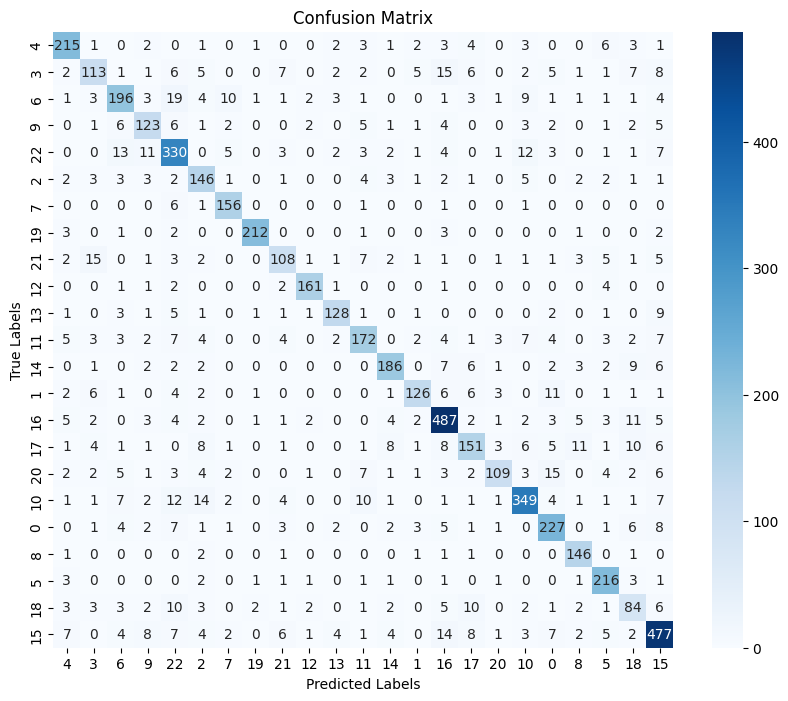

              precision    recall  f1-score   support

           4     0.8398    0.8669    0.8532       248
           3     0.7107    0.5979    0.6494       189
           6     0.7778    0.7368    0.7568       266
           9     0.7278    0.7455    0.7365       165
          22     0.7551    0.8271    0.7895       399
           2     0.6986    0.7978    0.7449       183
           7     0.8571    0.9398    0.8966       166
          19     0.9636    0.9422    0.9528       225
          21     0.7448    0.6708    0.7059       161
          12     0.9253    0.9306    0.9280       173
          13     0.8707    0.8205    0.8449       156
          11     0.7783    0.7319    0.7544       235
          14     0.8493    0.8122    0.8304       229
           1     0.8514    0.7326    0.7875       172
          16     0.8440    0.8936    0.8681       545
          17     0.7438    0.6623    0.7007       228
          20     0.8583    0.6301    0.7267       173
          10     0.8554    

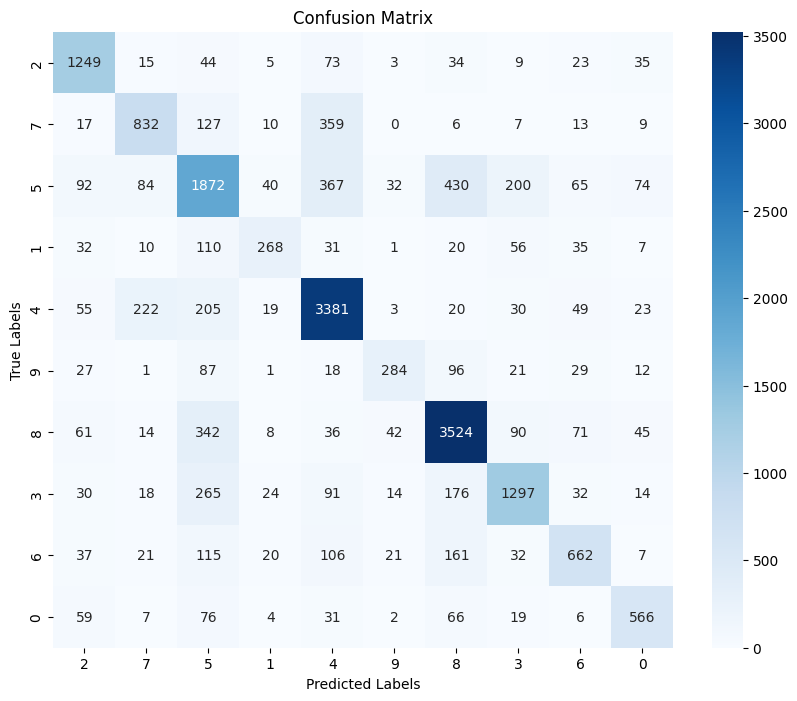

              precision    recall  f1-score   support

           2     0.7529    0.8383    0.7933      1490
           7     0.6797    0.6029    0.6390      1380
           5     0.5772    0.5749    0.5761      3256
           1     0.6717    0.4702    0.5531       570
           4     0.7525    0.8438    0.7955      4007
           9     0.7065    0.4931    0.5808       576
           8     0.7774    0.8325    0.8040      4233
           3     0.7365    0.6614    0.6969      1961
           6     0.6721    0.5601    0.6110      1182
           0     0.7146    0.6770    0.6953       836

    accuracy                         0.7149     19491
   macro avg     0.7041    0.6554    0.6745     19491
weighted avg     0.7117    0.7149    0.7106     19491

[[1249   15   44    5   73    3   34    9   23   35]
 [  17  832  127   10  359    0    6    7   13    9]
 [  92   84 1872   40  367   32  430  200   65   74]
 [  32   10  110  268   31    1   20   56   35    7]
 [  55  222  205   19 3381   

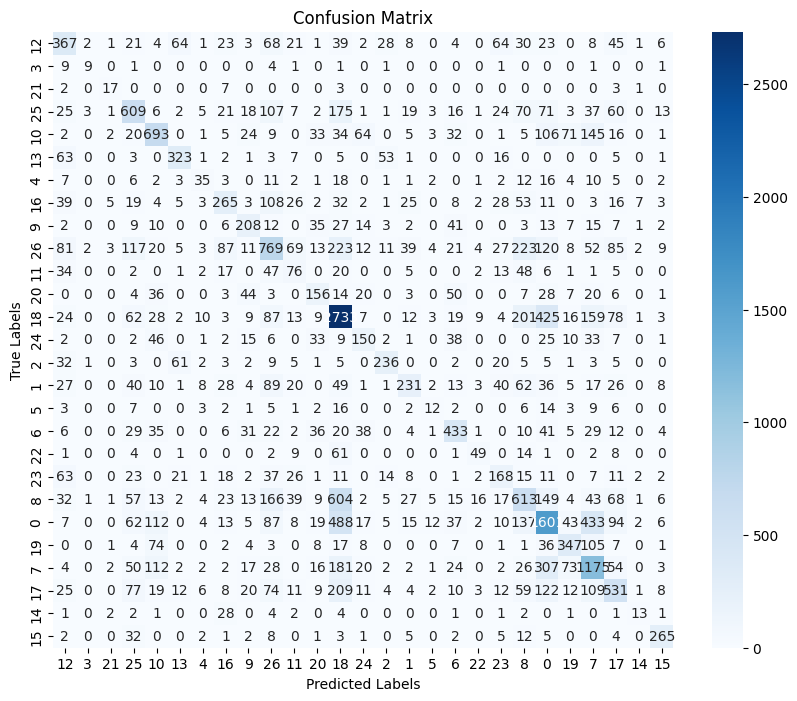

              precision    recall  f1-score   support

          12     0.4267    0.4400    0.4333       834
           3     0.5000    0.3103    0.3830        29
          21     0.4857    0.5152    0.5000        33
          25     0.4814    0.4685    0.4749      1300
          10     0.5657    0.5448    0.5551      1272
          13     0.6396    0.6674    0.6532       484
           4     0.3723    0.2431    0.2941       144
          16     0.4585    0.3955    0.4247       670
           9     0.4760    0.4988    0.4871       417
          26     0.4350    0.3807    0.4060      2020
          11     0.2203    0.2714    0.2432       280
          20     0.4031    0.3881    0.3954       402
          18     0.5465    0.6977    0.6129      3917
          24     0.4054    0.3916    0.3984       383
           2     0.6413    0.5885    0.6138       401
           1     0.5513    0.3204    0.4053       721
           5     0.2400    0.1277    0.1667        94
           6     0.5573    

In [21]:
print('----artist part per-class acc----')
class_names = [str(name) for name in artist_val["label"].unique().tolist()]
report, cm = per_class_accuracy(model_Alex_artist, model_Res_artist, val_loader_artist_f, device, class_names, 0.4, 0.6)
print(report)
print(cm)

print('----genre part per-class acc----')
class_names = [str(name) for name in genre_val["label"].unique().tolist()]
report, cm = per_class_accuracy(model_Alex_genre, model_Res_genre, val_loader_genre_f, device, class_names, 0.6, 0.4)
print(report)
print(cm)

print('----style part per-class acc----')
class_names = [str(name) for name in style_val["label"].unique().tolist()]
report, cm = per_class_accuracy(model_Alex_style, model_Res_style, val_loader_style_f, device, class_names, 0.7, 0.3)
print(report)
print(cm)